# Hip-Hop/ Rap Lyrics

In [2]:
# Imports
import requests
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
import plotly.express as px
import spacy
import random

from dotenv import load_dotenv
from collections import Counter
from collections import defaultdict
from PIL import Image
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import ngrams
from spacy import displacy
from nltk.lm import MLE # language model
from nltk import word_tokenize, sent_tokenize
from nltk.util import pad_sequence, bigrams, ngrams, everygrams
from nltk.lm.preprocessing import pad_both_ends, flatten, padded_everygram_pipeline
from nltk.tokenize.treebank import TreebankWordDetokenizer

In [3]:
# Load .env environment variables
load_dotenv()

# Set RAPID API key
# my_rapid_api_key = os.getenv("RAPID_API_KEY")

True

In [4]:
# Define function to use Shazam Core API

def get_chart_genre(querystring):

    url = "https://shazam-core.p.rapidapi.com/v1/charts/genre-world"

    headers = {
    'x-rapidapi-host': "shazam-core.p.rapidapi.com",
    'x-rapidapi-key': '8b0d2ef776msh6040e496268c238p105edajsn055150f280c7'
    }

    response = requests.request("GET", url, headers=headers, params=querystring)

    return response.json()

In [5]:
# Define function to use Shazam Core API

def get_lyrics(querystring):

    url = "https://shazam-core.p.rapidapi.com/v1/tracks/details"

    headers = {
    'x-rapidapi-host': "shazam-core.p.rapidapi.com",
    'x-rapidapi-key': '8b0d2ef776msh6040e496268c238p105edajsn055150f280c7'
    }

    response = requests.request("GET", url, headers=headers, params=querystring)

    return response.json()

In [6]:
# Use 'Track details' endpoint to retrieve lyrics for a single track

genre = 'HIP_HOP_RAP'
limit_songs = 50

querystring = {"genre_code":genre,"limit":limit_songs}
chart_response = get_chart_genre(querystring)

In [7]:
# Retrieve Track IDs

track_ids=[] # song identifier
titles = [] # song name
subtitles = [] # Main artist and featured artists

for track in range(len(chart_response)):
    track_ids.append(chart_response[track]['id'])
    titles.append(chart_response[track]['title'])
    subtitles.append(chart_response[track]['subtitle'])

print(f"The number of songs retrieved is : {len(track_ids)}")

chart_songs = pd.DataFrame({"Track Name": titles, "Artists": subtitles, 'TrackIDs': track_ids}).set_index('TrackIDs')
chart_songs.head(5)

The number of songs retrieved is : 50


,Track Name,Artists
TrackIDs,,
41264695,Bananza (Belly Dancer),Akon
590362040,TO THE MOON,Jnr Choi
578340247,INDUSTRY BABY,Lil Nas X & Jack Harlow
579792092,Own Brand Freestyle,FelixThe1st & Dreya Mac Feat. Finch Fetti
565785367,น้ำแดงน้ำส้ม,JV.JARVIS


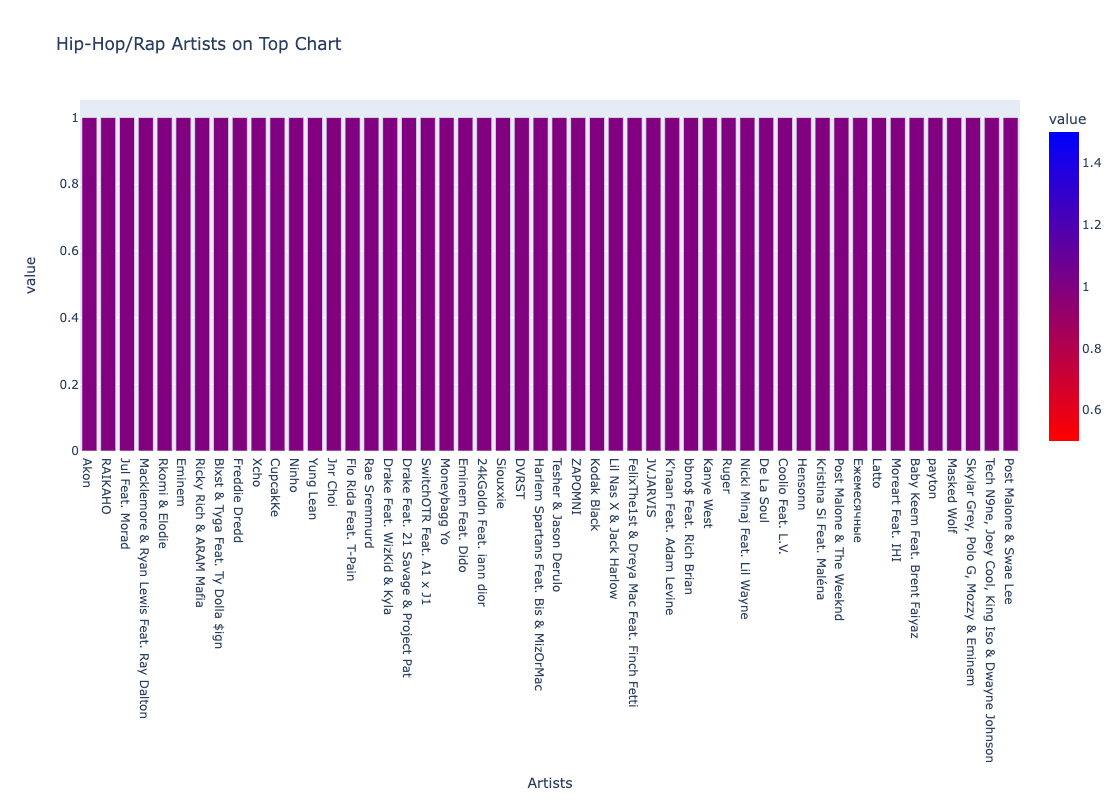

In [60]:
# Look at the data

# from collections import Counter

artists_list = list(chart_songs.Artists)
artist_counts = {artist: artists_list.count(artist) for artist in artists_list} #dict with frequency of artist in top chart

artists_df = pd.DataFrame(list(artist_counts.items()),columns = ['Artists','No. Songs in Top Chart']).set_index('Artists')
artists_df.sort_values(by = 'No. Songs in Top Chart', ascending=False, inplace=True) #sort values

fig2 = px.bar(
    artists_df,
    color = "value",
    color_continuous_scale='Bluered_r',
    title = 'Hip-Hop/Rap Artists on Top Chart',
    height = 800
)
fig2.show()


In [9]:
# Retrieve Lyrics for all TrackIDs

track_ids  # the list created in "Search for top songs in Genre" section is required

lyrics=[]

for trackID in track_ids:
    querystring = {"track_id":trackID}
    track_details_response = get_lyrics(querystring)

    if track_details_response['sections'][1]['type'] != "LYRICS":  # Note: tracks with a type != "LYRICS" don't contain lyrics
        lyrics.append([''])
    else:
        track_lyrics = track_details_response['sections'][1]['text']
        lyrics.append(track_lyrics)

In [10]:
# Add lyrics column to dataframe with chart songs

all_lyrics = pd.Series(" ".join(map(str,song)) for song in lyrics) #each song is stored as a list, this turns each list into a string
all_lyrics_df = pd.DataFrame({"Lyrics": all_lyrics, "Track IDs": track_ids}).set_index('Track IDs')

lyrics_df = pd.concat([chart_songs, all_lyrics_df], axis=1)
lyrics_df.head(5)

,Track Name,Artists,Lyrics
41264695,Bananza (Belly Dancer),Akon,"Hey, ladies drop it down Just want to see you ..."
590362040,TO THE MOON,Jnr Choi,Pull up the ting gon' turn up Pull up the ting...
578340247,INDUSTRY BABY,Lil Nas X & Jack Harlow,"D-D-Daytrip took it to ten (hey) Baby back, a..."
579792092,Own Brand Freestyle,FelixThe1st & Dreya Mac Feat. Finch Fetti,Little niggas really wan' at me (at me) Lockdo...
565785367,น้ำแดงน้ำส้ม,JV.JARVIS,คัมซามิดา สวัสดีค้าบ ในกระเป๋าไม่มียา ชอบไปรัช...


In [11]:
lyrics_df.head(50)

,Track Name,Artists,Lyrics
41264695,Bananza (Belly Dancer),Akon,"Hey, ladies drop it down Just want to see you ..."
590362040,TO THE MOON,Jnr Choi,Pull up the ting gon' turn up Pull up the ting...
578340247,INDUSTRY BABY,Lil Nas X & Jack Harlow,"D-D-Daytrip took it to ten (hey) Baby back, a..."
579792092,Own Brand Freestyle,FelixThe1st & Dreya Mac Feat. Finch Fetti,Little niggas really wan' at me (at me) Lockdo...
565785367,น้ำแดงน้ำส้ม,JV.JARVIS,คัมซามิดา สวัสดีค้าบ ในกระเป๋าไม่มียา ชอบไปรัช...
52510207,Bang Bang,K'naan Feat. Adam Levine,"She shot me, she shot me Bang, bang... she sho..."
577235374,edamame,bbno$ Feat. Rich Brian,Balls hanging low while I pop a bottle off a y...
578737070,Praise God,Kanye West,"That she wrote, Speech to the Young: Speech to..."
591239041,Dior,Ruger,"Hmm, oh-yeah-oh Bad man lookin' good in Dior ..."
74992451,High School,Nicki Minaj Feat. Lil Wayne,He said he came from Jamaica He owned a couple...


In [12]:
lyrics_df.tail(50)

,Track Name,Artists,Lyrics
41264695,Bananza (Belly Dancer),Akon,"Hey, ladies drop it down Just want to see you ..."
590362040,TO THE MOON,Jnr Choi,Pull up the ting gon' turn up Pull up the ting...
578340247,INDUSTRY BABY,Lil Nas X & Jack Harlow,"D-D-Daytrip took it to ten (hey) Baby back, a..."
579792092,Own Brand Freestyle,FelixThe1st & Dreya Mac Feat. Finch Fetti,Little niggas really wan' at me (at me) Lockdo...
565785367,น้ำแดงน้ำส้ม,JV.JARVIS,คัมซามิดา สวัสดีค้าบ ในกระเป๋าไม่มียา ชอบไปรัช...
52510207,Bang Bang,K'naan Feat. Adam Levine,"She shot me, she shot me Bang, bang... she sho..."
577235374,edamame,bbno$ Feat. Rich Brian,Balls hanging low while I pop a bottle off a y...
578737070,Praise God,Kanye West,"That she wrote, Speech to the Young: Speech to..."
591239041,Dior,Ruger,"Hmm, oh-yeah-oh Bad man lookin' good in Dior ..."
74992451,High School,Nicki Minaj Feat. Lil Wayne,He said he came from Jamaica He owned a couple...


In [13]:
# Remove songs without lyrics

lyrics_df.drop(lyrics_df.loc[lyrics_df['Lyrics'] == ''].index.tolist(), inplace=True)
lyrics_df.head(5)

,Track Name,Artists,Lyrics
41264695,Bananza (Belly Dancer),Akon,"Hey, ladies drop it down Just want to see you ..."
590362040,TO THE MOON,Jnr Choi,Pull up the ting gon' turn up Pull up the ting...
578340247,INDUSTRY BABY,Lil Nas X & Jack Harlow,"D-D-Daytrip took it to ten (hey) Baby back, a..."
579792092,Own Brand Freestyle,FelixThe1st & Dreya Mac Feat. Finch Fetti,Little niggas really wan' at me (at me) Lockdo...
565785367,น้ำแดงน้ำส้ม,JV.JARVIS,คัมซามิดา สวัสดีค้าบ ในกระเป๋าไม่มียา ชอบไปรัช...


In [14]:
lyrics_df.tail(50)

,Track Name,Artists,Lyrics
41264695,Bananza (Belly Dancer),Akon,"Hey, ladies drop it down Just want to see you ..."
590362040,TO THE MOON,Jnr Choi,Pull up the ting gon' turn up Pull up the ting...
578340247,INDUSTRY BABY,Lil Nas X & Jack Harlow,"D-D-Daytrip took it to ten (hey) Baby back, a..."
579792092,Own Brand Freestyle,FelixThe1st & Dreya Mac Feat. Finch Fetti,Little niggas really wan' at me (at me) Lockdo...
565785367,น้ำแดงน้ำส้ม,JV.JARVIS,คัมซามิดา สวัสดีค้าบ ในกระเป๋าไม่มียา ชอบไปรัช...
52510207,Bang Bang,K'naan Feat. Adam Levine,"She shot me, she shot me Bang, bang... she sho..."
577235374,edamame,bbno$ Feat. Rich Brian,Balls hanging low while I pop a bottle off a y...
578737070,Praise God,Kanye West,"That she wrote, Speech to the Young: Speech to..."
591239041,Dior,Ruger,"Hmm, oh-yeah-oh Bad man lookin' good in Dior ..."
74992451,High School,Nicki Minaj Feat. Lil Wayne,He said he came from Jamaica He owned a couple...


In [15]:
#Remove empty lyrics
new_lyrics_df = lyrics_df.drop(
    [
        '565785367',
        '594606167',
        '370801349',
        '595827195',
        '594233500',
        '594403685',
        '594732573',
        '345849081',
        '594161539'
    ]
)
new_lyrics_df.head(50)

,Track Name,Artists,Lyrics
41264695,Bananza (Belly Dancer),Akon,"Hey, ladies drop it down Just want to see you ..."
590362040,TO THE MOON,Jnr Choi,Pull up the ting gon' turn up Pull up the ting...
578340247,INDUSTRY BABY,Lil Nas X & Jack Harlow,"D-D-Daytrip took it to ten (hey) Baby back, a..."
579792092,Own Brand Freestyle,FelixThe1st & Dreya Mac Feat. Finch Fetti,Little niggas really wan' at me (at me) Lockdo...
52510207,Bang Bang,K'naan Feat. Adam Levine,"She shot me, she shot me Bang, bang... she sho..."
577235374,edamame,bbno$ Feat. Rich Brian,Balls hanging low while I pop a bottle off a y...
578737070,Praise God,Kanye West,"That she wrote, Speech to the Young: Speech to..."
591239041,Dior,Ruger,"Hmm, oh-yeah-oh Bad man lookin' good in Dior ..."
74992451,High School,Nicki Minaj Feat. Lil Wayne,He said he came from Jamaica He owned a couple...
20056730,Gangsta's Paradise,Coolio Feat. L.V.,As I walk through the valley of the shadow of ...


In [16]:
new_lyrics_df.tail(50)

,Track Name,Artists,Lyrics
41264695,Bananza (Belly Dancer),Akon,"Hey, ladies drop it down Just want to see you ..."
590362040,TO THE MOON,Jnr Choi,Pull up the ting gon' turn up Pull up the ting...
578340247,INDUSTRY BABY,Lil Nas X & Jack Harlow,"D-D-Daytrip took it to ten (hey) Baby back, a..."
579792092,Own Brand Freestyle,FelixThe1st & Dreya Mac Feat. Finch Fetti,Little niggas really wan' at me (at me) Lockdo...
52510207,Bang Bang,K'naan Feat. Adam Levine,"She shot me, she shot me Bang, bang... she sho..."
577235374,edamame,bbno$ Feat. Rich Brian,Balls hanging low while I pop a bottle off a y...
578737070,Praise God,Kanye West,"That she wrote, Speech to the Young: Speech to..."
591239041,Dior,Ruger,"Hmm, oh-yeah-oh Bad man lookin' good in Dior ..."
74992451,High School,Nicki Minaj Feat. Lil Wayne,He said he came from Jamaica He owned a couple...
20056730,Gangsta's Paradise,Coolio Feat. L.V.,As I walk through the valley of the shadow of ...


In [17]:
# big_string = new_lyrics_df["Lyrics"].astype(str)
# big_string.dtype

# Tokenizer
In this section, I will use NLTK and Python to tokenize the text. This will include:

- Lowercase each word
- Remove Punctuation
- Remove Stopwords

In [18]:
# Instantiate the lemmatizer
lemmatizer = WordNetLemmatizer()

In [45]:
def tokenizer(Lyrics):
    """Tokenizes text."""
    # Create a list of the words
    words_tokened = word_tokenize(Lyrics)

    # Convert the words to lowercase
    words_lowered = [word.lower() for word in words_tokened]

    # Remove the punctuation
    regex = re.compile('[^a-zA-Z]')
    words_regexed = [regex.sub('', word) for word in words_lowered]
    
    # Remove the stop words
    sw = set(stopwords.words('english'))
    sw_add_ons = ['', 'the', 'a', 'at', 'for', 'above', 'ca', 'on', 'is', 'all', 'ai', 'nt', 'wan', 'na', 'uh', 'ay', 'ta', '(mmm)', 'Pengar', 'alla', 'shunos', 'här', 'väst', 'här', 'vill', 'ha', 'ladies', 'Paris-marseille-seille-seille', 'Ayy,', 'habibi,',  'Côt-côté',  'passager,',  'pote,', "c'était", 'mort', "j'ai", 'enveloppé', "l'corazon", 'puissant', "qu'on", 'enquête,', 'enquête', "n'a", "d'limite", 'nos.', 'rick-,', 'ri-,', '(jojo)','ricky', 'aram', 'mafia', 'hon', 'beaucoup', "d'choses", 'tête,', "j'veux", 'aller', 'mes', 'rêves', 'Déconné,', 'viens', 'déconné,', 'déconné', "t'es", "n'y", "j'assume", 'rôle,' 'trône,.','shit!', 'Tutti', 'miei', 'trucchi,', 'tuoi', 'capelli', 'rosa', '(oddio)', 'quegli', 'occhi', 'così', 'grandi,', "c'è", 'spazio', 'è.','coochie', '(slime)', 'bullets', 'bisexual', "(it's", 'Knew?', 'ho,', 'na-na-na-na', '(hey).','Воем', 'облака', 'сердце', 'тихо', 'плачет', 'болит,', 'но', 'нам', 'не', 'хватало', 'двоих', 'одной', 'любви', 'мало', 'нам.','vélodrome,', "l'double", 'clés', 'baissez', 'cagoules,', 'allumez', "l'moteur,", 'chargez', 'machins', '(chargez machins)', "l'club,", 'gov,.','tell?' 'regular?', 'Trois', 'assez', "n'pense", "qu'à", 'brasser?', "j'veux", 'quartier', 'vue', 'mer,', 'voulait', 'juste.','Cerchi', 'ti', 'sei', 'insinuata,', 'sinuosa', 'con', 'molti', 'nemici', '(aha)', 'shitty','ig?', '(mm)', 'halfway?','soos', 'mal', 'balanza', '¿millonarios', 'quieren', 'comprar', 'mi', "J'veux", 'vie,', 'matins', 'obscurs', 'goût', "d'déjà", 'vu', 'nuits', 'mortes', 'monde', "t'a", 'abandonné,', 'même', 'gentiment,.','opp,.','(ooh,.','Mecs', 'mettent', 'verre', "l'air", 'parfumé', 'avec', 'choupetta,', 'posé', 'gt3', 'poto,', "j'suis.",'Braquent', "'gasin", 'peine', 'fou,', 'ici,', 'sait', 'trucs', "j'ai", 'cote', "j'te", 'connais', 'lune', 'fin', 'désert.','(that grip)', "S'était", "t'es,", 'menaçant', 'g2b,', 'pi-pi-pi-pi-pi,', 'bezbar', 'puissanci', 'dis-leur', "qu'on", 'veut', 'montrer', "(yo'", 'son).','Bitch?','Best)', 'lines?', 'soos', 'mal', 'naaier.','H-', "t'arrache", 'prends.','kilode', 'ti,', 'kilode.',"T'pousses,", 'bouillants', 'braise', 'a7,', "d'sept,", "j'rentre", 'pété,', 'christian,', 'giuseppe', 'baiser,', 'métier,', 'parc', 'vélodrome,.''(big,',  'big.','Troverà', 'pa-pa-ra,', 'pussy,',  'depuis', 'toute', 'petite,' "m'a", 'dit', 'faut',  "d'oseilles", 'donc', 'mets', 'peine,', 'oui', 'teh', "j'espère", "qu'ils", 'comprendront', "j'suis", 'très', 'loin', 'terre', 'trois', 'assez',"n'pense", "qu'à", 'brasser?', 'quartier', 'vue', 'mer,', 'masser', 'voulait', 'juste', "êt'", 'libre,', "d'la", 'alors', 'nuit,', 'nuit', 'nos', 'rêves', "n'ont", "d'prix", 'alors', 'prie', 'crois-moi,', 'ferais', "qu'mes", 'se', 'réalisent','essayent', 'prendre', 'trône,', 'ouais', 'dit', 'leurs', "qu'ils", 'essaient', "j'en", 'vu', 'signes,', "j'en", 'suis', 'coup', "d'essai", 'combattu', 'binks', "j'suis", 'hautes', 'sphères', 'faut', 'viser', 'tête', 'veux', 'voir', 'tomber', "l'instant", "d'plan", 'b,', 'ouais', "d'la", 'tanger', 'déboussoler', "d'partout,", 'étranger,', 'ouais', 'trois', 'assez', "n'pense","qu'à", "j'veux",'réalisent', 'voulait', 'juste', "êt'", "d'la", 'alors', "n'ont", "d'prix", 'prie', 'crois-moi,', 'ferais', 'jojo', "qu'mes", 'réalisent', 'toute', 'är', 'farlig,', 'helt', 'olaglig', 'en', 'riktig', 'galning,', 'habibi', 'hon', 'är', 'tia', 'som', 'min', 'nya', 'mamacita,', 'habibi', 'hon', 'är', 'farlig,', 'helt', 'olaglig', 'en', 'riktig', 'galning,', 'habibi', 'som', 'min', 'nya', 'sjuk,', 'inget', 'normalt', 'pengar', 'hon', 'är', 'så', 'jet,', 'hon', 'är', 'benims', 'bästa', 'kram', 'för', 'varje', 'gång', 'träffas', 'så', 'får', 'jag', 'det', 'jag','skakar', 'sin', 'göt', 'gör', 'mig', 'hungrig,', 'feel', 'na-na-na,', 'guzzen', 'har', 'fått', 'mig', 'att', 'falla-la', 'jag', 'att', 'du', 'träffar', 'min', 'mamma-ma,', 'blicken', 'du', 'ger', 'mig', 'får', 'mig', 'aj,' 'du', 'är', 'så', 'sexig', 'sängen,', 'hetsig', 'baby,', 'felfri', 'olaglig', 'en', 'riktig', 'galning,', 'jane', 'stress', 'du', 'kicka', '3:30?', 'får', 'jag', 'casha', 'din', 'dress?', 'hur', 'du', 'slänger', 'ditt', 'hår', 'habibi,', 'på', 'en', 'annan', 'nivå', 'så', 'galen', 'när', 'dina', 'lår', 'nu', 'är', 'det', 'bara', 'hon', 'kan', 'dansa', 'du', 'och', 'jag,', 'kan', 'haffla', 'cashen', 'kastar', 'habibi,', 'vart', 'du', 'vill,' 'gör', 'shoutdown', 'habibi,', 'du', 'kan', 'ratta', 'min', 'c-klass', 'jag', 'kan', 'ge', 'dig', 'fyra', 'ringar', 'du', 'förtjänar', 'allt habibi,', 'farlig,', 'helt', 'olaglig', 'riktig', 'galning', 'nya', 'um', 'dois', 'três', 'quatro', 'ayy,', 'côtoie', 'pas,', 'c', 'est', 'sentimental'  'j',  'mon', 'bébé', 'est', 'nous', 'haïssent', 'qu', 'ils', 'veulent,',  'oh', 'yeah,.', 'ladies', "fuckin'", 'd-d-daytrip', 'créme', '(fucking', 'fuckin',  'dé', "motherfuckin'", 'fuckin', 'fucking', "mutherfuckin'", '(doctor)', 'fais', 'Cashen', 'vi', 'två', 'D-D-Daytrip', 'よ！', 'じゃぁ 行こうぞ！', '-)', 'D', 'sha', 'ba', 'RGF', '(no)', 'too–)', '"felix', 'nuff)', '(pally)', 'start)', '(nah', 'baddie)', '(like,', '(you', '(with', '(wait)', 'rgf', '(bitch)', 'bitches,', '(smoke)', 'caress)', 'bluff)', '(ah,', '(bitch,', '"bitch,',   '(just',  'up)', 'bitch!', 'dope)', 'dick', '(', '(ayy, ayy)', '(wet)', '(hah)', 'ジャンケンポン！', '(', ')', 'dddaytrip', '(ohh)', '(you look too–)', '-', 'all-all', '(nah)', 'that)', '(yeah)', 'me)', '(calm)', 'u[p', '(at', ' me)', 'b', '(ah ah)', '(ah', 'ah', 'ah)', '(uh-huh)', '(hey',  'girl)', 'ah', '(valleys)', '(cali)', 'stuff)', 'nigga', 'niggas', 'niggas?"', 'niggas,', 'shit', 'fuck', 'bitch', 'bitch,', 'fucked', 'pussy', 'hoe', 'motherfucker', 'bitches', 'Temps,', 'v', '-esqui',  'les', 'jnouns,', 'hein,', 'mais', 'pas', 'tout', 'ça)', 'oh,', 'bébé,', 'si', 'tu', 'demandes', 'pourquoi.', '(c', 'mon)', 'chefi',  'toto', 'beats', 'plus', 'de', 'dialogue', '(non)', 'jour', 'meilleur', 'rira', 'quand', 'coeur', 'rempli', 'chansons', 'qui', 'refleurissent', 'broke-ass', 'aj', 'jet', 'ski', 'rör', 'vill,' 'allt', 'jet', 'aj,' 'aj', 'um,', 'dois,', 'três,', 'marche', 'arrière', '(ouais,', 'ouais)', 'love,', 'pour', 'moi', 'ça', '(ouais, ouais)', 'des', 'hauts,', 'des', 'bas,', 'vie', 'd', 'ghetto,', 'vie', 'vit', 'ça,', 'mwana', 'boka', 'vient', 'blocka', 'vivra', 'verra,', 's','assagit', 'cœur', 'pirate,' 'fallait', 'peu', 'pour', 'finir', 'ensemble,', 'trop', 'promesses', 'au', 'portable', 'pour', 'ton', 'ça', 'pète,' 'ramasser', 'douillеs,', 'cogne', 'pour', 'deux', '(cogne pour deux)', 'barre',  'lumière', 'dans', 'le', 'noir,', 'je', 'sens', 'bien', 'près', 'toi', 'il', 'n' 'y', 'perdre', 'temps,', 'ai',  'fait', 'serré', '(j', 'ai', 'déconné,' 'viens', 'm', 'faire', 'un', 'busa)', 's', 'est', 'promis', 's','aimer', '(tu', 'sais', 'pourquoi', 'fait', 't','es', 'seul,', 'seul', 'la,', 'lala,', 'une', 'fille', 'à', 'toutes', 'saisons', 'l', 'amour', 'd', 'un', 'garçon', 'ay,', 'dreya', 'Время', 'тает', 'как', 'же', 'было', 'увидаться', 'пропитанная', 'дымом', 'так', 'хотел', 'с', 'тобой', 'на', 'дне', 'сгорала.', 'Печаль', 'покидают', 'силы,', 'мило', 'остаться', 'я', 'тобою', 'навек', 'веки', 'тяжелы', 'и', 'лжи', 'она', 'инь-янь', 'искала,.', 'Remplir', 'l', 'biberon', 'bambin', 'ah,', 'plein', 'crush,', 'nageuse', 'norme,', 'bugatti', 'divo', 'est', 'jolie,', 'elle,', 'c', 'est',  'dе.', 'Guérilla,', 'là', 'tartine,', 'dort,', 'que', 'paroles', 'et', "m'aimes,", 'tant.', 'bahia', 'é', 'capitão', 'areia', 'garoto', 'abandonado', "d'avancer", "l'verra",  'sous', 'meilleur,', 'problème', 'la', "c'est", "qu'y", "qu'une", 'soignera', 'jamais', 'la', 'dépression', 'comme', 'soigne', 'rhume', 'dis-toi', 'pourras', 'compter', 'sur', 'temps', "qu'ça" 'dure', 'allergique', 'la', "'écouter", 'va', 'changer,', 'enfin,', 'sauf', "l'fais", "t'as", "l'désert", 'traverser,', 'rien', 'faire,', 'sauf', 'rien', 'sauf', "d'variét", 'où', 'meufs', 'sont', 'tous', 'morceaux', "(j'ai", 'déconné,' 'viens', "m'faire", "s'est", "s'aimer", "j'fait"]
    stopwords_removed = [word.lower() for word in words_regexed if word not in sw.union(sw_add_ons)]

    # Lemmatize Words into root words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in stopwords_removed]

    return tokens

In [46]:
# Create a new tokens column for lyrics
lyrics_tokens = [tokenizer(words) for words in new_lyrics_df['Lyrics']]
new_lyrics_df['Tokens'] = lyrics_tokens
new_lyrics_df.head()

,index,Track Name,Artists,Lyrics,Tokens
0,41264695,Bananza (Belly Dancer),Akon,"Hey, ladies drop it down Just want to see you ...","[hey, drop, want, see, touch, ground, shy, gir..."
1,590362040,TO THE MOON,Jnr Choi,Pull up the ting gon' turn up Pull up the ting...,"[pull, ting, gon, turn, pull, ting, gon, turn,..."
2,578340247,INDUSTRY BABY,Lil Nas X & Jack Harlow,"D-D-Daytrip took it to ten (hey) Baby back, a...","[took, ten, hey, baby, back, ayy, couple, rack..."
3,579792092,Own Brand Freestyle,FelixThe1st & Dreya Mac Feat. Finch Fetti,Little niggas really wan' at me (at me) Lockdo...,"[little, really, lockdown, still, doin, cali, ..."
4,52510207,Bang Bang,K'naan Feat. Adam Levine,"She shot me, she shot me Bang, bang... she sho...","[shot, shot, bang, bang, shot, shot, shot, ban..."


In [47]:
# new_lyrics_df.reset_index(inplace=True)
# new_lyrics_df

In [48]:
new_lyrics_df[['Lyrics', 'Tokens']]

,Lyrics,Tokens
0,"Hey, ladies drop it down Just want to see you ...","[hey, drop, want, see, touch, ground, shy, gir..."
1,Pull up the ting gon' turn up Pull up the ting...,"[pull, ting, gon, turn, pull, ting, gon, turn,..."
2,"D-D-Daytrip took it to ten (hey) Baby back, a...","[took, ten, hey, baby, back, ayy, couple, rack..."
3,Little niggas really wan' at me (at me) Lockdo...,"[little, really, lockdown, still, doin, cali, ..."
4,"She shot me, she shot me Bang, bang... she sho...","[shot, shot, bang, bang, shot, shot, shot, ban..."
5,Balls hanging low while I pop a bottle off a y...,"[ball, hanging, low, pop, bottle, yacht, chain..."
6,"That she wrote, Speech to the Young: Speech to...","[wrote, speech, young, speech, progress, towar..."
7,"Hmm, oh-yeah-oh Bad man lookin' good in Dior ...","[hmm, ohyeahoh, bad, man, lookin, good, dior, ..."
8,He said he came from Jamaica He owned a couple...,"[said, came, jamaica, owned, couple, acre, cou..."
9,As I walk through the valley of the shadow of ...,"[walk, valley, shadow, death, take, look, life..."


# Calculating VADER Sentiment Score for LYRICS

As you know the `compound` score could be used to get a normalized score for a sentiment. We create a function called `get_sentiment(score)` that will return a normalized value of sentiment for the `score` parameter based on the rules. This function should return `1` for positive sentiment, `-1` for negative sentiment, and `0` for neutral sentiment.

In [49]:
# Download/Update the VADER Lexicon
nltk.download("vader_lexicon")

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/moniqueferguson/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [50]:
# Sentiment calculation based on compound score
def get_sentiment(score):
    """
    Calculates the sentiment based on the compound score.
    """
    result = 0  # Neutral by default
    if score >= 0.05:  # Positive
        result = 1
    elif score <= -0.05:  # Negative
        result = -1

    return result


In [51]:
# Sentiment scores dictionaries
lyrics_sent = {
    "lyrics_compound": [],
    "lyrics_pos": [],
    "lyrics_neu": [],
    "lyrics_neg": [],
    "lyrics_sent": [],
}

# Get sentiment for the lyrics
for index, row in new_lyrics_df.iterrows():
    try:
        # Sentiment scoring with VADER
        lyrics_sentiment = analyzer.polarity_scores(row["Lyrics"])
        lyrics_sent["lyrics_compound"].append(lyrics_sentiment["compound"])
        lyrics_sent["lyrics_pos"].append(lyrics_sentiment["pos"])
        lyrics_sent["lyrics_neu"].append(lyrics_sentiment["neu"])
        lyrics_sent["lyrics_neg"].append(lyrics_sentiment["neg"])
        lyrics_sent["lyrics_sent"].append(get_sentiment(lyrics_sentiment["compound"]))

    except AttributeError:
        pass

# Attaching sentiment columns to the News DataFrame
lyrics_sentiment_df = pd.DataFrame(lyrics_sent)

# new_lyrics_df = new_lyrics_df.join(lyrics_sentiment_df)

# new_lyrics_df.head()
result_lyrics_df = pd.concat([new_lyrics_df, lyrics_sentiment_df], axis=1)
result_lyrics_df

,index,Track Name,Artists,Lyrics,Tokens,lyrics_compound,lyrics_pos,lyrics_neu,lyrics_neg,lyrics_sent
0,41264695,Bananza (Belly Dancer),Akon,"Hey, ladies drop it down Just want to see you ...","[hey, drop, want, see, touch, ground, shy, gir...",0.9904,0.158,0.754,0.087,1
1,590362040,TO THE MOON,Jnr Choi,Pull up the ting gon' turn up Pull up the ting...,"[pull, ting, gon, turn, pull, ting, gon, turn,...",0.4215,0.076,0.887,0.036,1
2,578340247,INDUSTRY BABY,Lil Nas X & Jack Harlow,"D-D-Daytrip took it to ten (hey) Baby back, a...","[took, ten, hey, baby, back, ayy, couple, rack...",0.9967,0.161,0.801,0.038,1
3,579792092,Own Brand Freestyle,FelixThe1st & Dreya Mac Feat. Finch Fetti,Little niggas really wan' at me (at me) Lockdo...,"[little, really, lockdown, still, doin, cali, ...",0.9968,0.224,0.636,0.140,1
4,52510207,Bang Bang,K'naan Feat. Adam Levine,"She shot me, she shot me Bang, bang... she sho...","[shot, shot, bang, bang, shot, shot, shot, ban...",0.9943,0.128,0.828,0.044,1
5,577235374,edamame,bbno$ Feat. Rich Brian,Balls hanging low while I pop a bottle off a y...,"[ball, hanging, low, pop, bottle, yacht, chain...",0.9719,0.169,0.717,0.113,1
6,578737070,Praise God,Kanye West,"That she wrote, Speech to the Young: Speech to...","[wrote, speech, young, speech, progress, towar...",0.7701,0.110,0.796,0.094,1
7,591239041,Dior,Ruger,"Hmm, oh-yeah-oh Bad man lookin' good in Dior ...","[hmm, ohyeahoh, bad, man, lookin, good, dior, ...",-0.9879,0.103,0.737,0.160,-1
8,74992451,High School,Nicki Minaj Feat. Lil Wayne,He said he came from Jamaica He owned a couple...,"[said, came, jamaica, owned, couple, acre, cou...",0.9947,0.178,0.753,0.069,1
9,20056730,Gangsta's Paradise,Coolio Feat. L.V.,As I walk through the valley of the shadow of ...,"[walk, valley, shadow, death, take, look, life...",0.9917,0.170,0.722,0.108,1


### Analyzing Sentiments Results

The sentiment of the lyrics


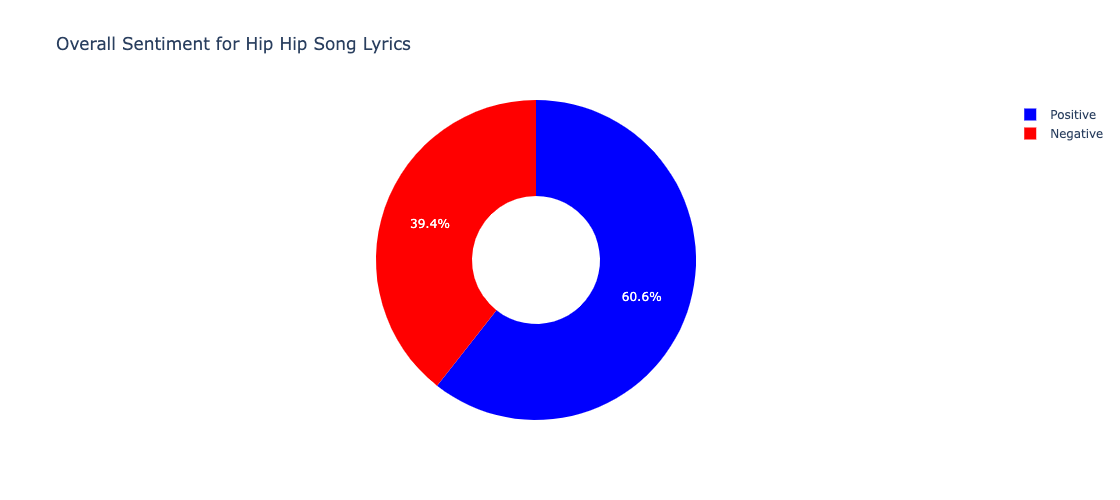

In [52]:
# Plot overall sentiment scores for genre

positives = result_lyrics_df['lyrics_sent'].loc[result_lyrics_df['lyrics_sent'] == 1 ].count()
negatives = result_lyrics_df['lyrics_sent'].loc[result_lyrics_df['lyrics_sent'] == -1 ].count()
index_names = ['Positive', 'Negative']

lyrics_sentiment = pd.DataFrame([positives,negatives], columns = ['Count'])
lyrics_sentiment.index = index_names

hiphop_sentiment_pie = px.pie(
    lyrics_sentiment, 
    values = 'Count', 
    names=index_names,
    hover_name = index_names,
    hole = 0.4, 
    color_discrete_sequence=["blue", "red"], 
    width=1000, 
    height = 500,
    title='Overall Sentiment for Hip Hip Song Lyrics'
    )  
hiphop_sentiment_pie

In [53]:
# Describe lyrics sentiment
result_lyrics_df.describe()

,lyrics_compound,lyrics_pos,lyrics_neu,lyrics_neg,lyrics_sent
count,33.000000,33.000000,33.000000,33.000000,33.000000
mean,0.210112,0.137182,0.738394,0.124455,0.212121
std,0.931786,0.047382,0.065058,0.064075,0.992395
min,-0.999000,0.043000,0.599000,0.035000,-1.000000
25%,-0.979500,0.103000,0.700000,0.088000,-1.000000
50%,0.958700,0.142000,0.737000,0.107000,1.000000
75%,0.991700,0.169000,0.794000,0.153000,1.000000
max,0.997800,0.251000,0.887000,0.288000,1.000000


# NGrams and Frequency Analysis
In this section there are the ngrams and word frequency for lyrics.

Use NLTK to produce the n-grams for N = 2.

In [54]:
# Generate the Lyrics N-grams where N=2
lyrics_text = ' '.join(result_lyrics_df["Lyrics"])
lyrics_processed = tokenizer(lyrics_text)
lyrics_ngrams = Counter(ngrams(lyrics_processed, n=2))
print(dict(lyrics_ngrams.most_common(60)))

{('low', 'low'): 56, ('shot', 'shot'): 29, ('girl', 'go'): 28, ('money', 'make'): 28, ('yeah', 'yeah'): 24, ('bang', 'bang'): 24, ('one', 'right'): 21, ('masquerade', 'masquerade'): 21, ('doin', 'dope'): 21, ('bad', 'man'): 19, ('big', 'energy'): 17, ('hit', 'floor'): 17, ('let', 'get'): 16, ('go', 'round'): 16, ('shot', 'bang'): 15, ('make', 'world'): 14, ('world', 'go'): 14, ('make', 'girl'): 14, ('drop', 'want'): 13, ('want', 'see'): 13, ('shake', 'ya'): 13, ('rumble', 'gon'): 13, ('gon', 'take'): 13, ('take', 'yo'): 13, ('yo', 'face'): 13, ('could', 'u'): 13, ('contagious', 'doin'): 13, ('hey', 'drop'): 12, ('see', 'touch'): 12, ('touch', 'ground'): 12, ('ground', 'shy'): 12, ('shy', 'girl'): 12, ('go', 'bananza'): 12, ('ya', 'body'): 12, ('body', 'like'): 12, ('pull', 'ting'): 12, ('ting', 'gon'): 12, ('gon', 'turn'): 12, ('bang', 'shot'): 12, ('ayy', 'ayy'): 12, ('spendin', 'life'): 12, ('life', 'livin'): 12, ('livin', 'gangsta'): 12, ('gangsta', 'paradise'): 12, ('alright', 'bab

In [55]:
# Use the token_count function to generate the top 50 words from the lyrics
def token_count(Tokens, N=50):
    """Returns the top N tokens from the frequency count"""
    return Counter(Tokens).most_common(N)

In [56]:
# Use token_count to get the top 50 words from rnb lyrics
lyrics_top_50 = token_count(lyrics_processed)
lyrics_top_50

[('like', 232),
 ('got', 139),
 ('yeah', 116),
 ('go', 101),
 ('want', 100),
 ('know', 99),
 ('one', 97),
 ('back', 92),
 ('get', 82),
 ('low', 77),
 ('girl', 75),
 ('right', 65),
 ('make', 64),
 ('let', 61),
 ('see', 59),
 ('cause', 55),
 ('gon', 55),
 ('could', 55),
 ('man', 51),
 ('shot', 51),
 ('tell', 50),
 ('bad', 50),
 ('big', 48),
 ('baby', 47),
 ('say', 46),
 ('bang', 46),
 ('ayy', 46),
 ('way', 43),
 ('money', 43),
 ('give', 42),
 ('put', 42),
 ('time', 40),
 ('need', 39),
 ('love', 38),
 ('u', 35),
 ('hey', 34),
 ('hit', 34),
 ('really', 33),
 ('em', 33),
 ('ya', 31),
 ('life', 31),
 ('better', 31),
 ('look', 30),
 ('take', 30),
 ('come', 29),
 ('masquerade', 29),
 ('never', 28),
 ('round', 28),
 ('think', 28),
 ('face', 28)]

In [57]:
# Create df for most common tokens

lyrics_top50_df = pd.DataFrame(lyrics_top_50, columns=['Word', 'Count']).set_index('Word')
lyrics_top50_df

,Count
Word,
like,232
got,139
yeah,116
go,101
want,100
know,99
one,97
back,92
get,82


In [62]:
# Export Top Words dataframe to CSV
lyrics_top50_df.to_csv('hiphop_top_words.csv')

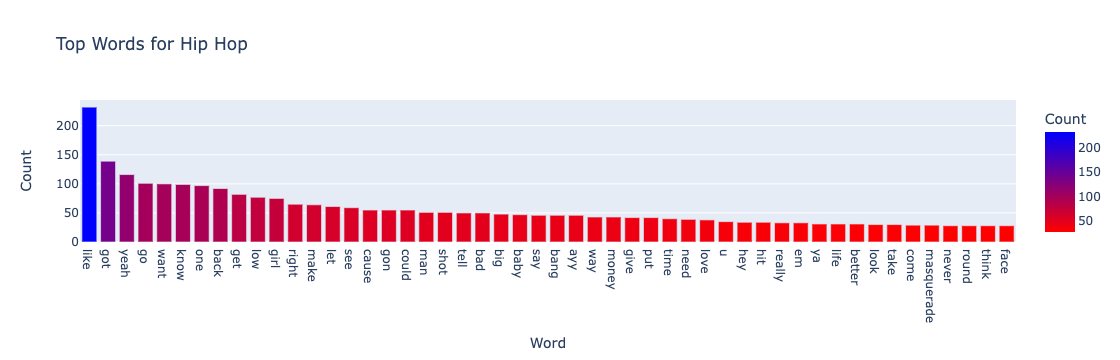

In [58]:
# Plot most common tokens
lyrics_top50_plot = px.bar(
    lyrics_top50_df,
    y = 'Count',
    color = "Count",
    color_continuous_scale='Bluered_r',
    title ='Top Words for Hip Hop'
)
lyrics_top50_plot

# Hip Hop Word Cloud

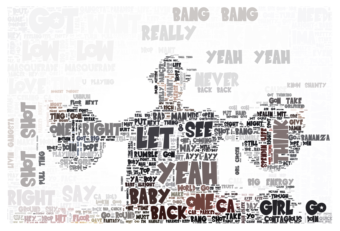

In [32]:
# # Generate the Hip Hop word cloud
lyrics_words_joined = ' '.join(lyrics_processed)

font_path = 'Resources/saiyan_sans/Saiyan-Sans.ttf'

mask = np.array(Image.open('Images/a.jpeg'))

mask_colors = ImageColorGenerator(mask)

wc = WordCloud(background_color="white", font_path=font_path, max_words=2000, mask = mask, max_font_size=256,
               random_state=42, width=mask.shape[1], height=mask.shape[0], color_func=mask_colors)
wc.generate(lyrics_words_joined)
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

In [33]:
# Save image as png
# wccc.to_file("Images/hiphopboom.png")

# Named Entity Recognition
In this section, you will build a named entity recognition model for the hip hop lyrics, then visualize the tags using SpaCy.

In [34]:
# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

In [35]:
# Run the NER processor on all of the text
hiphop_ner = nlp(lyrics_text)

# Add a title to the document
hiphop_ner.user_data['title'] = 'Hip Hop/Rap NER'

In [ ]:
# Render the visualization
# displacy.render(hiphop_ner, style='ent')

In [36]:
# List all Entities

ent_labels=[]
entities=[]

for ent in hiphop_ner.ents:
    ent_labels.append(ent.label_)
    entities.append(ent.text)

# Obtain frequency for each named entity

entities_freq = pd.DataFrame.from_dict([Counter(entities)]).T
entities_freq.columns = ['Frequency']
entities_freq.sort_values(by= 'Frequency', ascending=False, inplace = True)


# Retrieve labels for unique named entities

unique_nes = entities_freq.index.tolist()

labels = []

for word in unique_nes:
    idx = entities.index(word)
    label = ent_labels[idx]
    labels.append(label)

entities_freq['Label'] = labels

entities_freq

,Frequency,Label
bang,27,GPE
Bang,18,GPE
One,15,CARDINAL
one,13,CARDINAL
Livin,12,GPE
...,...,...
Bastard,1,ORG
Muhammad Ali,1,PERSON
Rosa Parks,1,PERSON
Huey P.,1,PERSON


In [37]:
# Bar chart of frequencies of Named Entities

entities_count = pd.DataFrame.from_dict([Counter(ent_labels)]).T
entities_count.columns = ['Count']

entities_count.sort_values('Count',inplace=True, ascending=False)

entities_count.reset_index(inplace=True)
entities_count = entities_count.rename(columns = {'index':'Named_Entity'})

entities_count.head()



,Named_Entity,Count
0,PERSON,187
1,ORG,153
2,GPE,107
3,CARDINAL,68
4,DATE,31


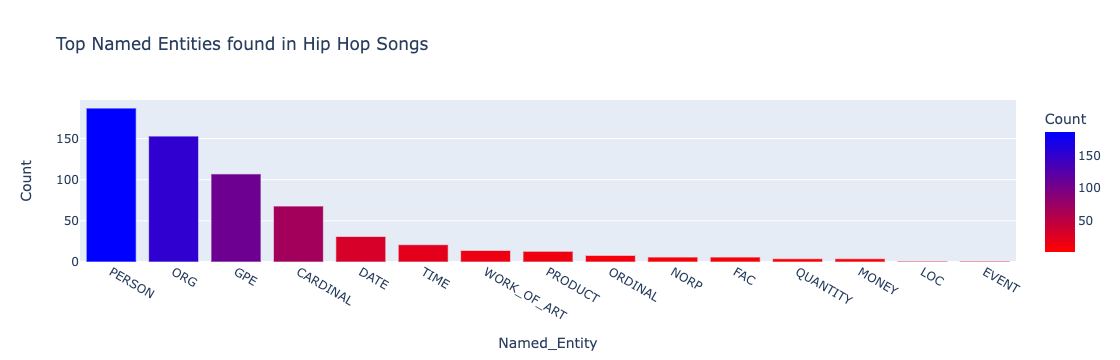

In [40]:
fig = px.bar(
    entities_count,
    x="Named_Entity",
    y="Count",
    color = "Count",
    color_continuous_scale='Bluered_r',
    title = "Top Named Entities found in Hip Hop Songs"
     )
fig.show()

In [39]:
# Export Entities dataframe to CSV
# entities_count.to_csv('hiphop_entities_count.csv', index=False)

# Build a Markov Chain Function
We are going to build a simple Markov chain function that creates a dictionary:

- The keys should be all of the words in the corpus
- The values should be a list of the words that follow the keys

In [ ]:
from collections import defaultdict

def markov_chain(text):
    '''The input is a string of text and the output will be a dictionary with each word as
       a key and each value as the list of words that come after the key in the text.'''
    
    # Tokenize the text by word, though including punctuation
    words = text.split(' ')
#     for t in text:
#         words = t.split(' ')
#         print(words[0])
    
    # Initialize a default dictionary to hold all of the words and next words
    m_dict = defaultdict(list)
    
    # Create a zipped list of all of the word pairs and put them in word: list of next words format
    for current_word, next_word in zip(words[0:-1], words[1:]):
        m_dict[current_word].append(next_word)

    # Convert the default dict back into a dictionary
    m_dict = dict(m_dict)
    return m_dict

In [ ]:
# Create the dictionary for lyrics, take a look at it

lyrics_dict = markov_chain(lyrics_text)
lyrics_dict

# Create a Text Generator
We're going to create a function that generates sentences. It will take two things as inputs:

- The dictionary you just created
- The number of words you want generated

In [ ]:
import random

def generate_sentence(chain, count=8):
    '''Input a dictionary in the format of key = current word, value = list of next words
       along with the number of words you would like to see in your generated sentence.'''

    # Capitalize the first word
    word1 = random.choice(list(chain.keys()))
    sentence = word1.capitalize()

    # Generate the second word from the value list. Set the new word as the first word. Repeat.
    for i in range(count-1):
        word2 = random.choice(chain[word1])
        word1 = word2
        sentence += ' ' + word2

    # End it with a period
    sentence += '.'
    return(sentence)

In [ ]:
# lines = []
# line = []

# num_sentences=32

# with open('markov_hiphop1.txt', 'w') as file:
#     file.write('Hip Hop Song by Markov Chains')
#     file.write('\n')
#     file.write('------------------------------------------')
#     file.write('\n')

#     for num in range(0,num_sentences):
#         line = generate_sentence(lyrics_dict)
#         lines.append(line)
#         file.write(line)
#         file.write('\n')

# Maximum Likelihood Estimator (MLE) Algorithm

Using Language Model Module (nltk.lm) from NLTK library

In [ ]:
# Tokenize lyrics corpus
lyrics_corpus = list(new_lyrics_df['Lyrics'].apply(word_tokenize))

In [ ]:
# Preprocess the tokenized text for 4-grams language modelling
n = 4
train_data, padded_sents = padded_everygram_pipeline(n, lyrics_corpus)

In [ ]:
# Train and fit the model
hiphop_model = MLE(n) # Lets train a 4-grams model
hiphop_model.fit(train_data, padded_sents)

In [ ]:
# Clean up the generated tokens to make it human-like.

detokenize = TreebankWordDetokenizer().detokenize

def generate_sent(model, num_words, random_seed):
    """
    :param model: An ngram language model from `nltk.lm.model`.
    :param num_words: Max no. of words to generate.
    :param random_seed: Seed value for random.
    """
    content = []
    for token in model.generate(num_words, random_seed=random_seed):
        if token == '<s>':
            continue
        if token == '</s>':
            break
        content.append(token)
    return detokenize(content)

In [66]:
# Predict text
mle_text = generate_sent(hiphop_model, num_words=280, random_seed=128)
len(mle_text)  

# Note: pick a random seed that gives you 1000+ characters as the len(mle_text) 
# or run the generate_sent again until you hit your target size of lyrics

NameError: name 'generate_sent' is not defined

In [ ]:
# Save predicted lyrics as a .txt file

# with open('mle_hiphop.txt', 'w') as file:
#     file.write(mle_text)

# Save MLE Predicted Lyrics to Audio

In [64]:
from gtts import gTTS 
import os

In [65]:
speech = gTTS(text = mle_text, lang = 'en', slow = True)
speech.save("hiphop_mle_text.mp4")

NameError: name 'mle_text' is not defined